In [57]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.linear_model import LinearRegression
import numpy as np
from regression_model import RegressionModel
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, LSTM
from LSTM_model import LSTMModel
import os
import re

In [58]:
def get_dataframe(filename):
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df["Unnamed: 0"], dayfirst=True)
    df.drop(["Unnamed: 0"],axis='columns', inplace=True)
    columns = list(df.columns)
    numerics = [x for x in columns[2:-3] if 'Cross' not in x and x not in ['MACD','Settle_Price']]
    for col in numerics:
        df[col+'norm'] = df[col] / df['Settle_Price'] - 1
    return df

In [59]:
def get_data_by_years(df, years, features, label):
    ydf = df[df.Date.map(lambda x: x.year in years)]
    return ydf[features], ydf[label]

In [60]:
def get_data(df, data_start, valid_start, test_start, data_end, features, label):
    data = {}
    train_years = list(range(data_start,  valid_start))
    valid_years = list(range(valid_start, test_start))
    test_years  = list(range(test_start,  data_end))
    data['Xtrain'], data['Ytrain'] = get_data_by_years(df, train_years, features, label)
    data['Xvalid'], data['Yvalid'] = get_data_by_years(df, valid_years, features, label)
    data['Xtest'],  data['Ytest']  = get_data_by_years(df, test_years,  features, label)
    return data

In [61]:
features = ['MACD', 'Volume']
label = 'Daily_Return'
features_directory = 'data'
data_start = 1990
valid_start = 2010
test_start = 2014
data_end = 2018

In [62]:
for i, filename in enumerate(os.listdir(features_directory)):
    if not re.match(filename, ".DS_Store"):
        df = get_dataframe(features_directory + '/' + filename)
        data = get_data(df, data_start, valid_start, test_start, data_end, features, label)
        print(filename)
        X = data['Xtrain']
        Y = data['Ytrain']
        model = LSTMModel()
        model.train(X, Y)
        output = {}
        output['predicted_'+str(i)] = model.predict(data['Xtest'])
        output['true_'+str(i)] = data['Ytest']
returns_df = pd.DataFrame(output)

Copper_2.csv


NameError: name 'model' is not defined

In [ ]:
trainsplit = int(len(Y) * 0.9)
validsplit = trainsplit #+ int(len(Y) * 0.1)
Xtrain = X[:trainsplit]
Ytrain = Y[:trainsplit]
Xvalid = X[trainsplit:validsplit]
Yvalid = Y[trainsplit:validsplit]
Xtest = X[validsplit:]
Ytest = Y[validsplit:]

In [33]:
Ytrain.values

array([-0.0103317 , -0.01318681, -0.00612472, ..., -0.00074349,
       -0.01388889,  0.00385647])

In [8]:
model = RegressionModel()
model.train(Xtrain, Ytrain)

[0.00025468]
[[6.48597348e-08]]
[0.00022098]
[[4.88335861e-08]]
[0.00017235]
[[2.9705766e-08]]
[0.00016149]
[[2.60776377e-08]]
[0.00017975]
[[3.23095593e-08]]


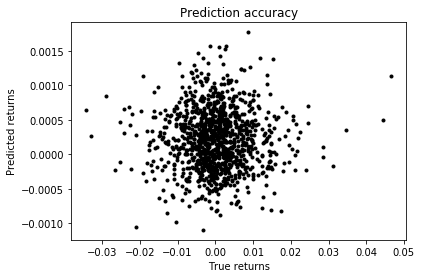

In [9]:
predicted_returns = model.predict(Xtest)
plt.plot(Ytest, predicted_returns, 'k.')
plt.title("Prediction accuracy")
plt.xlabel("True returns")
plt.ylabel("Predicted returns")

In [10]:
strongest_signal = np.max(predicted_returns)
Ytest = Ytest.values

In [11]:
# Long Only Portfolio
portfolio_weight = 1.0
portfolio_over_time = [1.0]
returns = []
max_bet_pct = 1.0 # Percent of holdings to risk on the best bet
for t in range(len(predicted_returns)):
    r_pred = predicted_returns[t]
    r_true = Ytest[t]
    if r_pred < 0:
        portfolio_over_time.append(portfolio_weight)
        returns.append(0.0)
        continue
        
    bet_size_pct = max_bet_pct * r_pred / strongest_signal
    bet_size_portfolio = portfolio_weight * bet_size_pct
    portfolio_weight = portfolio_weight + bet_size_portfolio * r_true
    portfolio_over_time.append(portfolio_weight)
    returns.append(r_true * bet_size_portfolio / portfolio_weight)

In [12]:
portfolio_weight

1.0092778505269269

Text(0,0.5,'Current:Original Holdings Ratio')

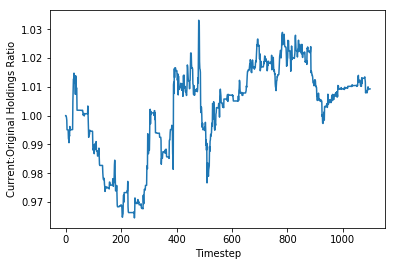

In [13]:
plt.plot(portfolio_over_time)
plt.xlabel("Timestep")
plt.ylabel("Current:Original Holdings Ratio")

(array([  1.,   2.,   0.,   4.,   3.,   4.,  16.,  38.,  79., 677., 168.,
         58.,  21.,  12.,   7.,   3.,   2.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.01409475, -0.01265764, -0.01122053, -0.00978341, -0.0083463 ,
        -0.00690919, -0.00547207, -0.00403496, -0.00259785, -0.00116073,
         0.00027638,  0.0017135 ,  0.00315061,  0.00458772,  0.00602484,
         0.00746195,  0.00889906,  0.01033618,  0.01177329,  0.0132104 ,
         0.01464752,  0.01608463,  0.01752175,  0.01895886,  0.02039597,
         0.02183309,  0.0232702 ,  0.02470731,  0.02614443,  0.02758154,
         0.02901865]),
 <a list of 30 Patch objects>)

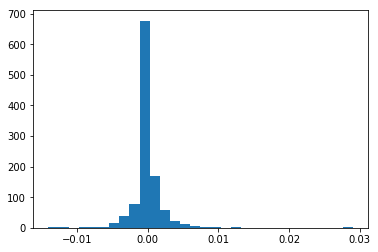

In [14]:
plt.hist(returns, bins=30)

In [15]:
from simple_portfolio import SimplePortfolio
returns = np.array([0.01])
optimizer = SimplePortfolio(1)
#print(optimizer.optimize(returns, 1e-5))
vals = returns_df[['predicted_0']].values[0:5,:]
np.apply_along_axis(lambda x: optimizer.optimize(x, 1e-6), 1, vals)

array([[0.99999996],
       [0.99999996],
       [0.99999995],
       [0.99999995],
       [0.99999996]])